<a href="https://colab.research.google.com/github/AaryaDesai1/Explainable_AI/blob/main/visualizing_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the notebook

## Installing necessary libraries and Importing them:
This was taken from Dr. Bent's `embedding-visualization` notebook. Also, ChatGPT was used to write up the markdowns explaining the three techniques. The following libraries were installed:
- `matplotlib`: To visualize the embedding space
- `scikit-learn`: To conduct dimensionality reduction using PCA and t-SNE
- `umap-learn`: To conduct the third form of dimensionality reduction selected for this assignment, i.e., UMAP.
- `plotly`: Also for visualization
- `transformers`: To use an embedding model from the MTEB leaderboard.

The necessary libraries were then imported in the following code cell, which has comments specifying what they were for.

In [ ]:
!pip install matplotlib==3.7.1 scikit-learn==1.2.2 umap-learn==0.5.6 plotly==5.15.0 transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [ ]:
# Base visulization libraries
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# For dimensionality reduction
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# For embeddings
from transformers import AutoModel, AutoTokenizer

## Loading the Model:
For this demo, I chose to use the `mixedbread-ai/mxbai-embed-2d-large-v1` model from the MTEB leaderboard. It ranked 49 on the leaderboard, with a model size of 335 million parameters, 1024 dimensions, and max otken length of 512. I chose this model as I have previous experience with it in a sentiment analysis project I conducted, and it performed extremely well. So, I am interested in seeing how it looks under the hood.

In [ ]:
# Loading the model
model_name = "mixedbread-ai/mxbai-embed-2d-large-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

# Using the Embeddings

## Creating a dataset
Here, I created a dataset with words from various categories/genres (this was done with the help of ChatGPT). I did this so that when we plot the embeddings, we can see the relationship between these words, possibly seeing genres clumping together in the 2D space.


In [ ]:
# Creating a dataset of strings to later embed
words = [
    # Nature & Environment
    "Tree", "Forest", "River", "Ocean", "Mountain", "Desert", "Rain", "Thunder", "Sunlight", "Earth",

    # Emotions & Feelings
    "Joy", "Sorrow", "Love", "Anger", "Fear", "Peace", "Excitement", "Nostalgia", "Hope", "Despair",

    # Technology & Innovation
    "Computer", "Internet", "Robot", "AI", "Quantum", "Blockchain", "Software", "Hardware", "Network", "Data",

    # Arts & Creativity
    "Music", "Dance", "Painting", "Sculpture", "Theater", "Literature", "Design", "Fashion", "Film", "Poetry",

    # Travel & Places
    "City", "Beach", "Mountain", "Desert", "Island", "Village", "Metropolis", "Countryside", "Ocean", "Skyline",

    # Food & Flavor
    "Sweet", "Sour", "Salty", "Bitter", "Savory", "Chocolate", "Cheese", "Wine", "Coffee", "Spice",

    # Time & Space
    "Future", "Past", "Present", "Infinity", "Eternity", "Moment", "Year", "Month", "Second", "Decade",

    # Abstract Concepts
    "Freedom", "Justice", "Equality", "Power", "Knowledge", "Wisdom", "Imagination", "Reality", "Truth", "Illusion"
]


## Functions for use

### `get_embeddings`
This function retrieves embeddings for a list of words using a pre-trained embedding model. It takes a list of words as input and returns a matrix of embeddings, with each word represented by a unique vector.

### `plot_with_annotations`
This function creates a static 2D scatter plot using `matplotlib` to visualize embeddings, adding each word as an annotation on the plot. It is useful for examining the relationships between words at a glance.

### `plot_with_px_scatter`
This function generates an interactive 2D scatter plot using `plotly.express`, allowing for zooming, panning, and hovering over each word to view its label. It provides a more dynamic way to explore clusters and word associations in the embedding space.

In [ ]:
# Creating a function to get embeddings from the text
def get_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Assuming the embeddings are in the last hidden state
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

embeddings = get_embeddings(words)

In [ ]:
# Define a helper function to plot and annotate points
def plot_with_annotations(result, title, annotations):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=result[:, 0], y=result[:, 1], s=100)
    for i, word in enumerate(annotations):
        plt.text(result[i, 0] + 0.1, result[i, 1] + 0.1, word, fontsize=9)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Plotting with Matplotlib

## PCA

### What is PCA?
Principal Component Analysis (PCA) is a dimensionality reduction technique commonly used in data science to reduce the number of features in a dataset while retaining as much variance (information) as possible. It transforms data into a set of orthogonal components, where each component captures the maximum variance possible in a given direction.

### How does it work?
PCA works by identifying the directions (principal components) along which the variance in the data is highest. It calculates these components by finding eigenvectors and eigenvalues of the covariance matrix, then projects the data onto the selected principal components. The components are ordered by their explained variance, so only the most informative components are typically retained.

### Strengths and Weaknesses
**Strengths**: PCA is effective for reducing dimensionality, which simplifies complex datasets and reduces computational costs. It is unsupervised and does not require labeled data. By reducing noise and redundancy, PCA can improve model performance on high-dimensional datasets.

**Weaknesses**: PCA assumes linearity, which limits its effectiveness on non-linear data structures. It can also be sensitive to outliers and may make data interpretation challenging, as transformed components do not retain the original feature meanings. Additionally, PCA may lose important information if too much dimensionality reduction is applied.


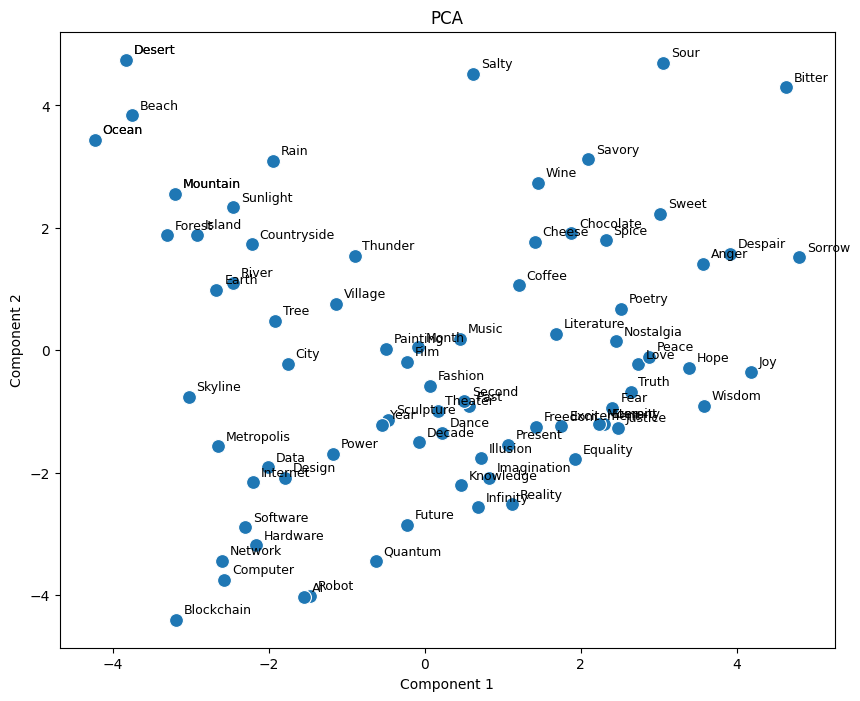

In [ ]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
plot_with_annotations(pca_result, 'PCA', words)

## t-SNE

### What is t-SNE?
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction technique designed primarily for visualizing high-dimensional data in 2 or 3 dimensions. It aims to represent data points that are similar to each other closely in the reduced-dimensional space.

### How does it work?
t-SNE works by converting the high-dimensional Euclidean distances between data points into conditional probabilities that represent similarities. It then attempts to find a lower-dimensional representation where these similarities are best preserved. This is achieved through iterative optimization to minimize the divergence between high-dimensional and low-dimensional distributions.

### Strengths and Weaknesses
**Strengths**: t-SNE is highly effective at revealing clusters in high-dimensional data and often outperforms linear techniques in detecting complex, non-linear patterns. It is particularly useful for visualizing structure in datasets like word embeddings or image features.

**Weaknesses**: t-SNE can be computationally expensive and is sensitive to hyperparameters, such as perplexity. It does not preserve global distances well, focusing more on local relationships, which can sometimes distort the larger structure of the data. It’s also generally limited to 2D or 3D representations, primarily for visualization.

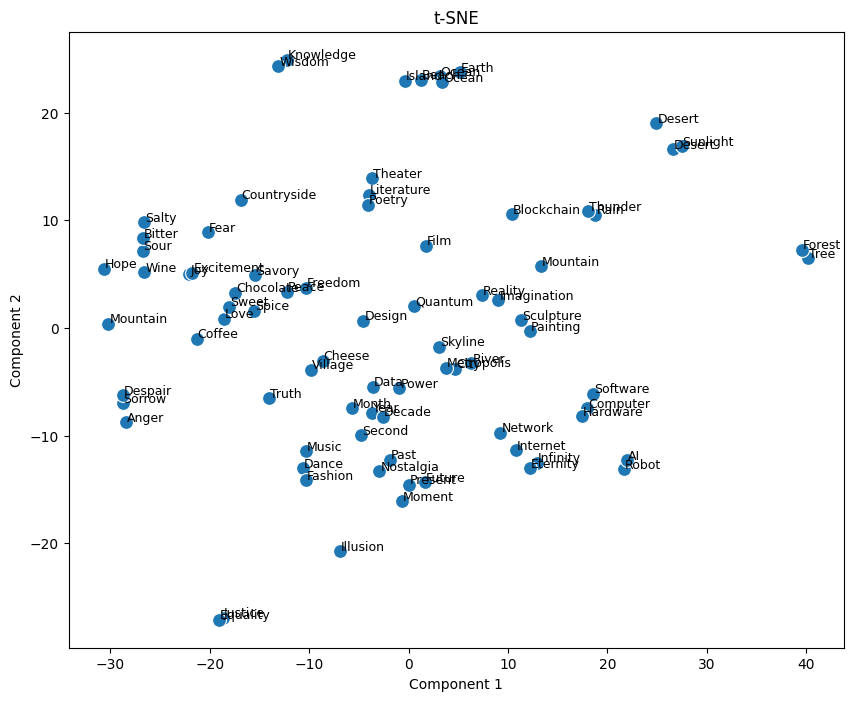

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=2, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(embeddings)
plot_with_annotations(tsne_result, 't-SNE', words)

## UMAP

### What is UMAP?
Uniform Manifold Approximation and Projection (UMAP) is a non-linear dimensionality reduction technique that is particularly good at preserving both local and global structures in data. Like t-SNE, it is widely used for visualizing complex datasets in lower dimensions.

### How does it work?
UMAP builds a graph representation of the high-dimensional data, then optimizes this graph to a lower-dimensional space. It preserves data structure by attempting to maintain relationships between points from the original high-dimensional space in the reduced space, based on manifold learning and Riemannian geometry.

### Strengths and Weaknesses
**Strengths**: UMAP is fast, scalable, and often better than t-SNE at preserving global structures, making it useful for large datasets. It also provides flexibility through its parameters, allowing for adjustments based on specific visualization needs, like cluster separation or smoother transitions.

**Weaknesses**: While UMAP tends to handle global and local structure better than t-SNE, it can sometimes create artifacts if the dataset does not align well with the underlying assumptions of manifold learning. The interpretation of UMAP projections, as with most non-linear techniques, can be challenging due to its non-deterministic nature.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


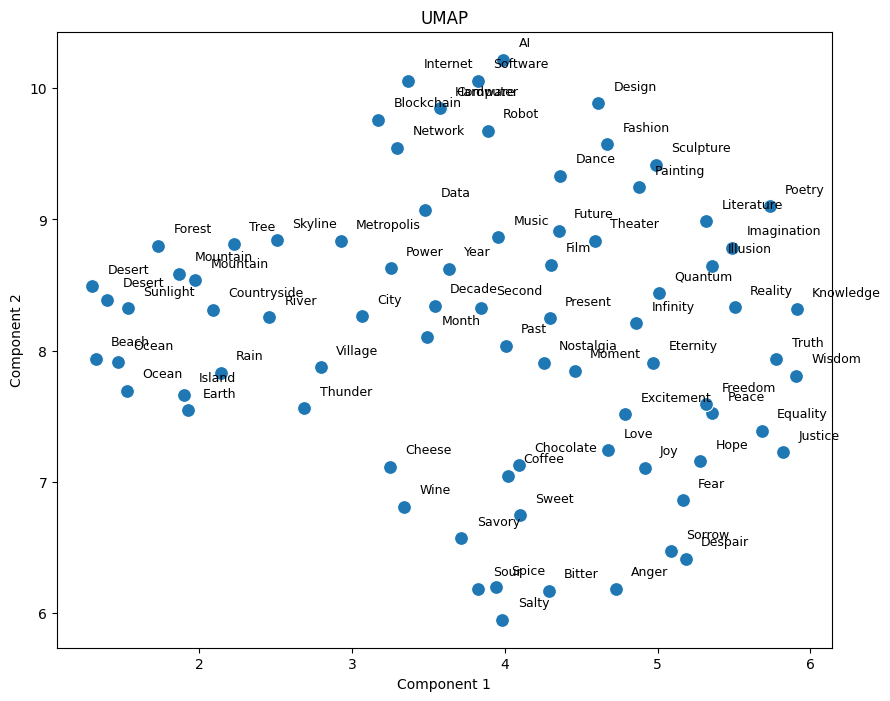

In [ ]:
# UMAP
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
plot_with_annotations(umap_result, 'UMAP', words)

## Plotting with plotly.express

In [ ]:
def plot_with_px_scatter(result, title, annotations):
    fig = px.scatter(
        x=result[:, 0],
        y=result[:, 1],
        text=annotations,   # Add annotations as hover text
        title=title,
        labels={'x': 'Component 1', 'y': 'Component 2'}
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.show()

plot_with_px_scatter(pca_result, 'PCA', words)
plot_with_px_scatter(tsne_result, 't-SNE', words)
plot_with_px_scatter(umap_result, 'UMAP', words)

# Comparing PCA, t-SNE, and UMAP

In this analysis, we used three dimensionality reduction techniques—PCA, t-SNE, and UMAP—to visualize the embedding space of words in different categories. Each method provided unique insights into the structure and relationships between different words in the embedding space.

**PCA**
The PCA plot captured the overall variance within the dataset by projecting the data onto its principal components. While PCA did a good job of preserving global structure, it showed less distinct separation between word clusters compared to the non-linear methods. This is likely due to PCA’s linear nature, which limits its ability to capture non-linear relationships. However, it is useful for initial assessments and helps to quickly gauge overall trends in the data.

**t-SNE**
The t-SNE plot highlighted clusters of words more clearly, with similar words appearing closer together (for example, Justice and Equality are almost overlapped). This technique excelled at preserving local relationships, making it easy to identify small groups of related terms. However, t-SNE did not maintain global structure as well, and some clusters may appear artificially separated. t-SNE’s tendency to emphasize local rather than global distances can give the impression of more discrete clusters, which might not fully represent the original structure.

**UMAP**
UMAP provided a balance between local and global structure, displaying distinct clusters while also preserving some of the larger relationships between groups of words. Compared to t-SNE, UMAP often better maintained both local and global relationships, allowing clusters to be more smoothly distributed. This approach gave a clearer view of potential transitions or overlapping areas between groups, making UMAP particularly valuable for datasets where both small and large-scale structures are relevant.

**Overall Comparison**
Each method offered unique advantages and limitations. PCA was useful for initial exploration of global structure, while t-SNE effectively visualized local clusters. UMAP struck a balance, preserving both local and global relationships more effectively. The choice of method ultimately depends on the specific visualization goals, but for this dataset, UMAP offered the most comprehensive view of the embedding space.

